In [2]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.manifold import TSNE

%matplotlib inline

Using TensorFlow backend.


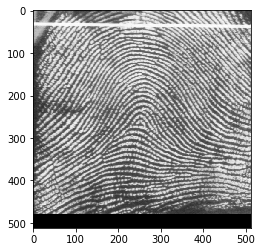

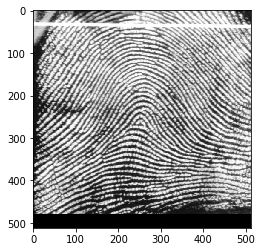

In [7]:
img = cv2.imread('./trainingSet/A/f0005_03.png', 0)
plt.imshow(img, cmap='Greys')
plt.show()
equ = cv2.equalizeHist(img)
plt.imshow(equ, cmap='Greys')
plt.show()

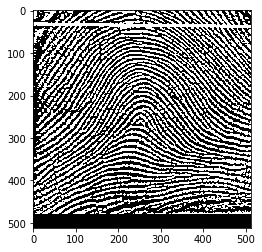

In [8]:
bin_img = cv2.adaptiveThreshold(equ,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,2)
plt.imshow(bin_img, cmap="Greys")

[[ 0  0  0 ..., 10  6  0]
 [32 36 40 ..., 14  8  0]
 [46 47 40 ..., 24 10  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]]


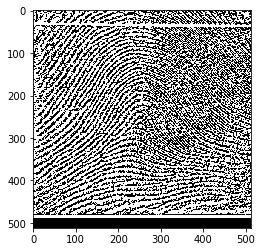

In [35]:
laplacian = cv2.Laplacian(equ,cv2.CV_8U)
sobelx = cv2.Sobel(equ,cv2.CV_8U,1,0,ksize=3)
sobely = cv2.Sobel(equ,cv2.CV_8U,0,1,ksize=3)
sobel = sobelx + sobely
print(sobel)
bin_img = cv2.adaptiveThreshold(sobel,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,2)
plt.imshow(bin_img, cmap="Greys")

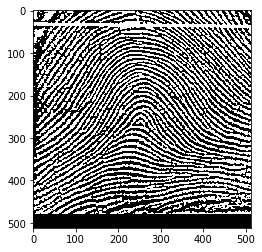

In [11]:
size = np.size(bin_img)
skel = np.zeros(bin_img.shape,np.uint8)
 
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
eroded = cv2.erode(bin_img,element)
dilated = cv2.dilate(eroded,element)

eroded = cv2.erode(dilated,element)
dilated = cv2.dilate(eroded,element)

skel = dilated
# done = False
 
# while( not done):
#     eroded = cv2.erode(bin_img,element)
#     temp = cv2.dilate(eroded,element)
    #temp = cv2.subtract(bin_img,temp)
    #skel = cv2.bitwise_or(skel,temp)
    #bin_img = eroded.copy()
 
    #zeros = size - cv2.countNonZero(bin_img)
    #if zeros==size:
     #   done = True
        
plt.imshow(skel, cmap="Greys")

In [43]:
types = ['A', 'L', 'R', 'T', 'W']
X_raw = []
y_raw = []
for i, t in enumerate(types):
    pics = os.listdir('trainingSet/{0}'.format(t))
    for name in pics:
        #print('trainingSet/{0}/{1}'.format(t, name))
        
        img = cv2.imread('trainingSet/{0}/{1}'.format(t, name),0)
        if img is not None:
            img = cv2.equalizeHist(img)
            #img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,2)
            img = cv2.resize(img, (100, 100))
            img = img / 255.0
            X_raw.append(img)
            y_raw.append(i)
            #print(i)
    


y_onehot = np.array(pd.get_dummies(y_raw))
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_onehot, test_size=0.2, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))   
X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))   
pickle.dump({
    'X_train' : X_train,
    'X_test' : X_test,
    'y_train' : np.array(y_train),
    'y_test' : np.array(y_test)   
}, open( "data.pickle", "wb" ) )

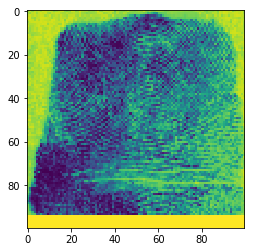

In [44]:
plt.imshow(X_raw[1])

In [6]:
os.listdir('testSet')

['s0682_08.png',
 's0085_10.png',
 'f0092_07.png',
 'f0194_10.png',
 'f1850_04.png',
 'f0307_05.png',
 'f0621_01.png',
 'f1045_04.png',
 'f0556_08.png',
 'f0752_08.png',
 'f0868_07.png',
 'f0466_10.png',
 'f1174_07.png',
 'f0147_06.png',
 'f0330_08.png']

In [5]:
X_test_raw = []
pics = os.listdir('testSet')
for name in pics:
    img = cv2.imread('testSet/{0}'.format(name),0)
    if img is not None:
        #img = cv2.equalizeHist(img)
        #img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,2)
        img = cv2.resize(img, (100, 100))
        img = img / 255.0
        X_test_raw.append(img)
        
pickle.dump({
    'X_test_raw' : X_test_raw
}, open( "test.pickle", "wb" ) )

In [ ]:
data = pickle.load(open('./data.pickle', 'rb'))

In [9]:
data = pickle.load(open('./data.pickle', 'rb'))
X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
y_train = np.array(data['y_train'])
y_test = np.array(data['y_test'])

In [21]:
X_train.shape

(3188, 100, 100, 1)

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [28]:
model.fit(X_train, y_train, batch_size=32, epochs=1, validation_data=(X_test, y_test), shuffle=True)
#results = model.evaluate(X_test, y_test, batch_size=32)
#print(results[1])

Train on 3188 samples, validate on 797 samples
Epoch 1/1
3188/3188 [==============================] - 50s - loss: 0.4851 - acc: 0.8341 - val_loss: 0.8964 - val_acc: 0.6662

In [23]:
X_train_flat = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_train_flat = pd.DataFrame(X_train_flat).fillna(0)

In [25]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(X_train_flat) 

In [7]:
reduced = pickle.load(open('./tsne_reduced.pickle', 'rb'))['tsne_reduced']
print(reduced)

[[ -6.35972661 -10.00533705]
 [ -7.42384656   0.13937656]
 [-10.38548352   4.80233084]
 ..., 
 [  4.18196285   6.33864033]
 [ 11.06010626  -2.35012721]
 [  6.70552255  -2.16573603]]


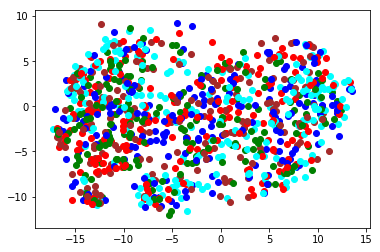

In [23]:
colors=['red','green','blue','brown','cyan']
#print(np.where(y_train[1]==1)[0][0])

for i, label in enumerate(reduced[:1000]):
    x, y = reduced[i,:]
    plt.scatter(x, y, color=colors[y_train[i].tolist().index(1)])
    
plt.show()

In [32]:
pickle.dump({
    'tsne_reduced' : reduced  
}, open( "tsne_reduced.pickle", "wb" ) )

In [ ]:
['1 s0682_08.png', W
 '2 s0085_10.png', T L
 '3 f0092_07.png', A
 '4 f0194_10.png', A
 '5 f1850_04.png', R
 '6 f0307_05.png', R
 '7 f0621_01.png', R
 '8 f1045_04.png', W
 '9 f0556_08.png', T L
 '10 f0752_08.png', R W
 '11 f0868_07.png', T
 '12 f0466_10.png', A T
 '13 f1174_07.png', R T
 '14 f0147_06.png', L
 '15 f0330_08.png'  A]